# Introduction

This notebook shows the use of [Azure AutoML](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml) on a (fake) variant data-set of multiple patients / samples.

The fake data-set is generated within the notebook. Its features are explained below.

The code used for AutoML is mainly taken from the [official tutorial on how to predict taxi fares](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-auto-train-models)

The notebook was run from within an Azure ML Notebook that's connected to a workspace. See this [tutorial]( https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-1st-experiment-sdk-setup) for how to get started.

## Initial Setup: Explainer Dashbboard

The Explainer Dashboard is used towards the end, but needs to be installed/enabled right at the start, official before the kernel is started. So I followed the instructions and restarted the kernel after the installation, since I was running this from within the ML Notebook. This is more straightforward if you are running your own Jupyter server, e.g on the Azure DSVM.

See also the official docs on [Model interpretability with Azure Machine Learning service](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability) and this [Github issue](https://github.com/Azure/MachineLearningNotebooks/issues/506)

In [1]:
! echo $PATH

/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/anaconda/envs/azureml_py36/bin/


In [2]:
! ps aux | grep jupyter | grep -v grep

azureus+   5863  0.1  0.1 388512 89596 ?        Ssl  03:19   0:24 /anaconda/envs/azureml_py36/bin/python /anaconda/envs/azureml_py36/bin/jupyter-notebook --no-browser --NotebookApp.token= --NotebookApp.disable_check_xsrf=True --NotebookApp.allow_origin=* --NotebookApp.allow_remote_access=True --MultiKernelManager.default_kernel_name=python3-azureml
azureus+  73086  126  0.2 1503976 167604 ?      Ssl  08:54   0:03 /anaconda/envs/azureml_py36/bin/python -m ipykernel_launcher -f /home/azureuser/.local/share/jupyter/runtime/kernel-40a69397-528c-4e5e-ace1-955ae93c742b.json


In [3]:
# not sure if sudo is needed. if yes, prepend /anaconda/envs/azureml_py36/bin/
! jupyter nbextension install --py --sys-prefix azureml.contrib.explain.model.visualize
! jupyter nbextension enable --py --sys-prefix azureml.contrib.explain.model.visualize
! conda install -y nb_conda

Installing /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/explain/model/visualize/static -> microsoft-mli-widget
Up to date: /anaconda/envs/azureml_py36/share/jupyter/nbextensions/microsoft-mli-widget/index.js
Up to date: /anaconda/envs/azureml_py36/share/jupyter/nbextensions/microsoft-mli-widget/extension.js.map
Up to date: /anaconda/envs/azureml_py36/share/jupyter/nbextensions/microsoft-mli-widget/index.js.map
Up to date: /anaconda/envs/azureml_py36/share/jupyter/nbextensions/microsoft-mli-widget/extension.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable azureml.contrib.explain.model.visualize --py --sys-prefix
    
Enabling notebook extension microsoft-mli-widget/extension...
      - Validating: OK
Solving environment: done

## Package Plan ##

  environment location: /anaconda

  added / updated specs: 
    - nb_conda


The following packages will b

`microsoft-mli-widget` is the widget we want.

In [4]:
! jupyter nbextension list

Known nbextensions:
  config dir: /anaconda/envs/azureml_py36/etc/jupyter/nbconfig
    notebook section
      azureml/kernel  enabled 
      - Validating: OK
      azureml_widgets/extension  enabled 
      - Validating: OK
      microsoft-mli-widget/extension  enabled 
      - Validating: OK
      microsoft-mli-widget/index  enabled 
      - Validating: OK
      nbdime/index  enabled 
      - Validating: OK
      jupyter-js-widgets/extension  enabled 
      - Validating: OK


# Create fake experiment 

- Generate fake variant calling matrix for a panel sequencing experiment 
- Rows: samples
- Columns: variant positions
- Values are 0 for ref, 1 for alt het and 2 for alt hom 

In [5]:
import pandas as pd
import numpy as np

In [6]:
# number of samples
num_samples = 500

# number of cases
num_cases = 200

# number of overall sites
num_sites = 100

# number of positions causal for phenotype
num_causal_sites = 2

# background mutation frequency
bg_mut_freq = 0.1

In [7]:
# create a random variant matrix containing: 0 ref, 1 alt het, 2 alt hom 
mat = np.random.choice(size=(num_samples, num_sites), 
                       a=[0, 1, 2],
                       p=[1-bg_mut_freq, bg_mut_freq/2, bg_mut_freq/2])


In [8]:
# assign gender randomly 
gender_transl = {1: 'male', 2: 'female', 3: 'unknown'}
gender_codes = list(gender_transl.keys())
gender = np.random.choice(size=(num_samples), a=gender_codes)

In [9]:
# determine which gender got unlucky
affected_gender = np.random.choice([k for k in gender_transl.keys() if k!='unknown'])
print("Affected gender = {} ({})".format(affected_gender, gender_transl[affected_gender]))

Affected gender = 2 (female)


In [10]:
# pick causal sites
import random
causal_sites = sorted(random.sample(range(num_sites), num_causal_sites))
print(causal_sites, " zero offset")

[49, 58]  zero offset


In [11]:
# set phenotype status to 0 for all samples
status = np.zeros(num_samples, dtype=int)

In [12]:
# pick cases randomly (saved in status array). set gender to affected gender.
# make sure that at least one randomly chosen causal site is set to alt hom
# 
for r in random.sample(range(num_samples), num_cases):
    status[r] = 1
    if not any([mat[r, c]==2 for c in causal_sites]):
        i = random.choice(causal_sites)
        mat[r, i] = 2
        gender[r] = np.random.choice([k for k,v in gender_transl.items() if k!=affected_gender])


Put it all into a Pandas dataframe

In [13]:
cols = ["site-{:d}".format(i+1) for i in range(num_sites)]
df = pd.DataFrame(data=mat, columns=cols)

In [14]:
ids = ["sample-{:d}".format(i+1) for i in range(num_samples)]
df.insert(loc=0, column='ID', value=ids)


In [15]:
df.insert(loc=1, column='Gender', value=gender)


In [16]:
df.insert(loc=2, column='Status', value=status)


In [17]:
df

,ID,Gender,Status,site-1,site-2,site-3,site-4,site-5,site-6,site-7,...,site-91,site-92,site-93,site-94,site-95,site-96,site-97,site-98,site-99,site-100
0,sample-1,3,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,sample-2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sample-3,3,1,0,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,sample-4,3,1,0,0,0,0,0,0,2,...,0,0,2,0,0,0,0,0,0,0
4,sample-5,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,sample-6,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
6,sample-7,2,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
7,sample-8,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,sample-9,1,1,0,0,1,0,0,0,0,...,0,0,2,0,0,0,2,0,0,0
9,sample-10,1,1,2,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1


In [18]:
df.shape


(500, 103)

In [19]:
# save for later use
df.to_csv("sample_matrix_clean.csv", index=False)
    

In [20]:
import pandas as pd

df = pd.read_csv("sample_matrix_clean.csv")


In [21]:
df

,ID,Gender,Status,site-1,site-2,site-3,site-4,site-5,site-6,site-7,...,site-91,site-92,site-93,site-94,site-95,site-96,site-97,site-98,site-99,site-100
0,sample-1,3,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,sample-2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sample-3,3,1,0,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,sample-4,3,1,0,0,0,0,0,0,2,...,0,0,2,0,0,0,0,0,0,0
4,sample-5,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,sample-6,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
6,sample-7,2,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
7,sample-8,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,sample-9,1,1,0,0,1,0,0,0,0,...,0,0,2,0,0,0,2,0,0,0
9,sample-10,1,1,2,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1


In [22]:
# keep a copy of the "annotation", i.e. all stuff that doesn't go into AutoML as features
annotation = df[["ID", "Status", "Gender"]].copy()
df = df.drop(["ID", "Status"], axis=1)


In [23]:
# Split into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, annotation['Status'], test_size=0.2, random_state=42)


# AutoML run (local)


A very cool feature in AutoML is automatic preprocessing (see `preprocess` below), which can automatically impute missing values, encode values, add features, embed words etc. See [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-create-portal-experiments#preprocess) for more information. Since the data-set here is clean already, there is no need for this. Plus, I couldn't get the Explainer below to work if preprocessing was on...

In [24]:
import logging

automl_settings = {
    "iteration_timeout_minutes": 1,
    "iterations": 10,
    "primary_metric": 'accuracy',
    "preprocess": False,
    "verbosity": logging.INFO,
    "n_cross_validations": 5
}

In [25]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(task='classification',
                             debug_log='automated_ml_errors.log',
                             X=X_train.values,
                             y=y_train.values.flatten(),
                             **automl_settings)

W0904 08:54:59.259974 140603231172352 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0904 08:54:59.261230 140603231172352 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



Connect to the ML workspace on Azure so that everything is logged there as well

In [26]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [27]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, "vcf-classification-local")
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_8bde3a84-39cb-410e-a79f-b631507cd3da
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper SGD                      0:00:10       0.8650    0.8650
         1   StandardScalerWrapper SGD                      0:00:10       0.8050    0.8650
         2   MinMaxScaler SGD                           

In [28]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

A Jupyter Widget

# Predict outcome

In [29]:
best_run, fitted_model = local_run.get_output()


In [30]:
print(best_run)


Run(Experiment: vcf-classification-local,
Id: AutoML_8bde3a84-39cb-410e-a79f-b631507cd3da_9,
Type: None,
Status: Completed)


In [31]:
print(fitted_model)

Pipeline(memory=None,
     steps=[('stackensembleclassifier', StackEnsembleClassifier(base_learners=[('7', Pipeline(memory=None,
     steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', ...7fe077de6710>,
           solver='lbfgs', tol=0.0001, verbose=0),
            training_cv_folds=5))])


In [32]:
y_predict = fitted_model.predict(X_test.values)
print("Sample\tPredicted\tActual")
for idx, (dfidx, dfrow) in enumerate(X_test.iterrows()):
    print("{}\t{}\t{}".format(annotation.at[dfidx, 'ID'], y_predict[idx], annotation.at[dfidx, 'Status']))
    # top 10 is enough
    if idx == 9:
        break
print("...")

Sample	Predicted	Actual
sample-362	1	0
sample-74	1	1
sample-375	0	0
sample-156	1	1
sample-105	0	0
sample-395	0	0
sample-378	1	1
sample-125	0	0
sample-69	1	1
sample-451	0	0
...


## Print stats and plot a confusion Matrix 

In [33]:
# idea from https://datatofish.com/confusion-matrix-python/
y_actual  = []
for dfidx, dfrow in X_test.iterrows():# what's the pandassy way of doing this?
    y_actual.append(annotation.at[dfidx, 'Status'])
    
data = {'y_Predicted': y_predict,
        'y_Actual': y_actual}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

In [34]:
# stats

from pandas_ml import ConfusionMatrix
Confusion_Matrix = ConfusionMatrix(df['y_Actual'], df['y_Predicted'])
Confusion_Matrix.print_stats()


population: 100
P: 43
N: 57
PositiveTest: 45
NegativeTest: 55
TP: 40
TN: 52
FP: 5
FN: 3
TPR: 0.9302325581395349
TNR: 0.9122807017543859
PPV: 0.8888888888888888
NPV: 0.9454545454545454
FPR: 0.08771929824561403
FDR: 0.1111111111111111
FNR: 0.06976744186046512
ACC: 0.92
F1_score: 0.9090909090909091
MCC: 0.8384183959931797
informedness: 0.8425132598939209
markedness: 0.8343434343434342
prevalence: 0.43
LRP: 10.604651162790699
LRN: 0.07647584973166369
DOR: 138.66666666666669
FOR: 0.05454545454545454


In [35]:
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'],
                               rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted   0   1
Actual           
0          52   5
1           3  40


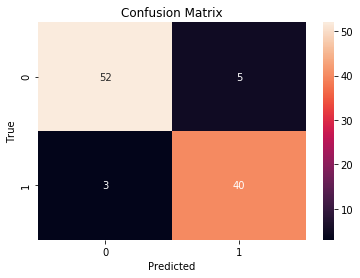

In [36]:
# idea from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
import seaborn as sn

import matplotlib.pyplot as plt     
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['business', 'health']); 
#ax.yaxis.set_ticklabels(['health', 'business']);

## Model Interpretability and Explainability

Microsoft has [six guiding AI principles](https://blogs.partner.microsoft.com/mpn/shared-responsibility-ai-2/). One of these is transparency, which states that it must be possible to understand how AI decisions were made. This is where [model interpretability](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability) comes into play. Here we will use a TabularExplainer to understand global behavior of our model. 

In [37]:
## Note, explainer doesn't work if preprocessing was used because, input column names cannot be
# found in fitted columns!?

from azureml.explain.model.tabular_explainer import TabularExplainer
# "features" and "classes" fields are optional. couldn't figure out how to use them
explainer = TabularExplainer(fitted_model, X_train)


In [38]:
# Now run the explainer. This takes some time...
global_explanation = explainer.explain_global(X_train)

A Jupyter Widget

In [39]:
# sorted feature importance values and feature names
sorted_global_importance_values = global_explanation.get_ranked_global_values()
sorted_global_importance_names = global_explanation.get_ranked_global_names()
## dict(zip(sorted_global_importance_names, sorted_global_importance_values))

# dictionary that holds the top K feature names and values
feature_importance = global_explanation.get_feature_importance_dict()

In [40]:
#for site, val in sorted(global_explanation.get_feature_importance_dict().items(), key=lambda x: x[1]):
#    print(site, val)
print("Top 10: ", ", ".join(sorted_global_importance_names[:10]))
print("Real causal sites {}".format(", ".join(["site-{:d}".format(i+1) for i in causal_sites])))


Top 10:  site-50, site-59, Gender, site-25, site-85, site-47, site-93, site-72, site-92, site-13
Real causal sites site-50, site-59


In [41]:
from azureml.contrib.explain.model.visualize import ExplanationDashboard

dashboard = ExplanationDashboard(global_explanation, fitted_model, X_train)

A Jupyter Widget

Nothing shows? See [this Github issue](https://github.com/Azure/MachineLearningNotebooks/issues/506)

Find the gender bias in the Explainer Dashboard...